<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj22-cv-intel-image-classification?scriptVersionId=193349515" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Intel Image Classification</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project focuses on the multi-class image classification of natural scenes using deep learning techniques. The dataset, provided by Intel, contains approximately 25,000 images of size 150x150, categorized into six different scene types: buildings, forests, glaciers, mountains, seas, and streets. By leveraging this dataset, the goal is to develop a model that can accurately classify images into these categories, providing insights into scene recognition and classification in computer vision.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Dropout , Flatten , Activation , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score

2024-08-20 18:38:02.134389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 18:38:02.134511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 18:38:02.315318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 99%|████████████████████████████████████████▍| 342M/346M [00:02<00:00, 193MB/s]
100%|█████████████████████████████████████████| 346M/346M [00:02<00:00, 162MB/s]


# **Data Preparation**
----

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'seg_test/seg_test',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
test_generator.classes 

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

# **Data Exploration**
----

In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


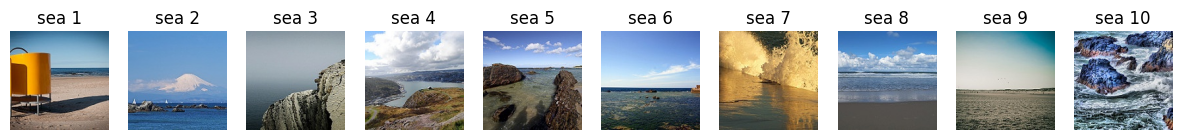

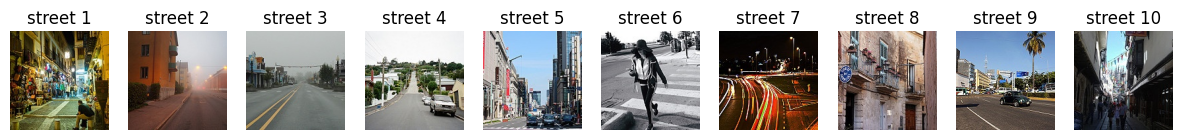

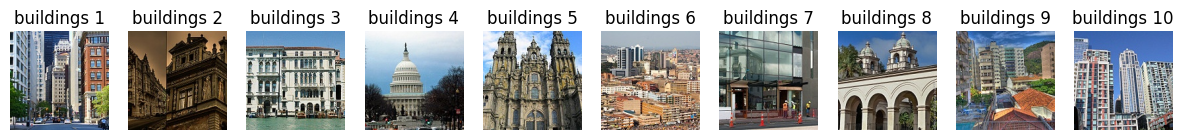

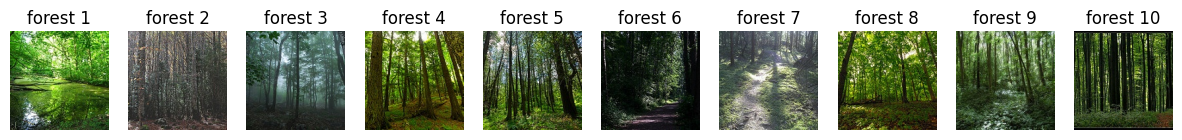

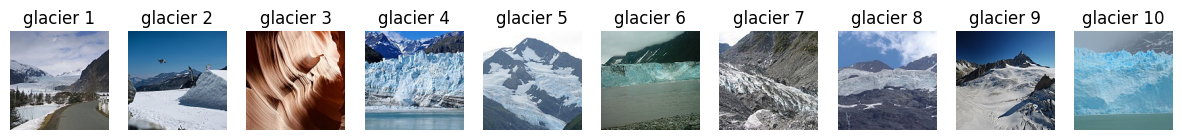

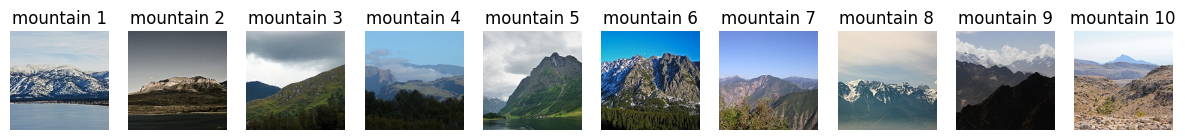

In [8]:
# Function to display images from multiple classes
def display_images_by_class(parent_folder, n_images=10):
    # Get the list of class folders
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

# Path to the parent directory containing class folders
parent_folder = 'seg_train/seg_train'

# Display images for each class in the parent folder
display_images_by_class(parent_folder, n_images=10)

# **Modeling**
----

In [9]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape = (255,255,3)))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))

model.add(Dense(6,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,274,854 (8.68 MB)

 Trainable params: 2,274,854 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [13]:
history = model.fit(train_generator,epochs=30,validation_data=val_generator, callbacks=[ES,RL])

Epoch 1/30
  2/351 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.1953 - loss: 1.7924   

I0000 00:00:1724179133.080006     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724179133.103733     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/351 ━━━━━━━━━━━━━━━━━━━━ 3:14 655ms/step - accuracy: 0.2883 - loss: 1.6454

W0000 00:00:1724179167.727343     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.4744 - loss: 1.2827

W0000 00:00:1724179299.179827     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 227s 591ms/step - accuracy: 0.4746 - loss: 1.2821 - val_accuracy: 0.6255 - val_loss: 0.9567 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1724179339.875717     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 549ms/step - accuracy: 0.6330 - loss: 0.9140 - val_accuracy: 0.7279 - val_loss: 0.7335 - learning_rate: 0.0010
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 550ms/step - accuracy: 0.7113 - loss: 0.7747 - val_accuracy: 0.7261 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 550ms/step - accuracy: 0.7437 - loss: 0.6752 - val_accuracy: 0.7743 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 548ms/step - accuracy: 0.7704 - loss: 0.6151 - val_accuracy: 0.8074 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 550ms/step - accuracy: 0.7897 - loss: 0.5715 - val_accuracy: 0.8031 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 551ms/step - accuracy: 0.8086 - loss: 0.5233 - val_accuracy: 0.8231 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 198s 555ms/step - accuracy: 0.8209 

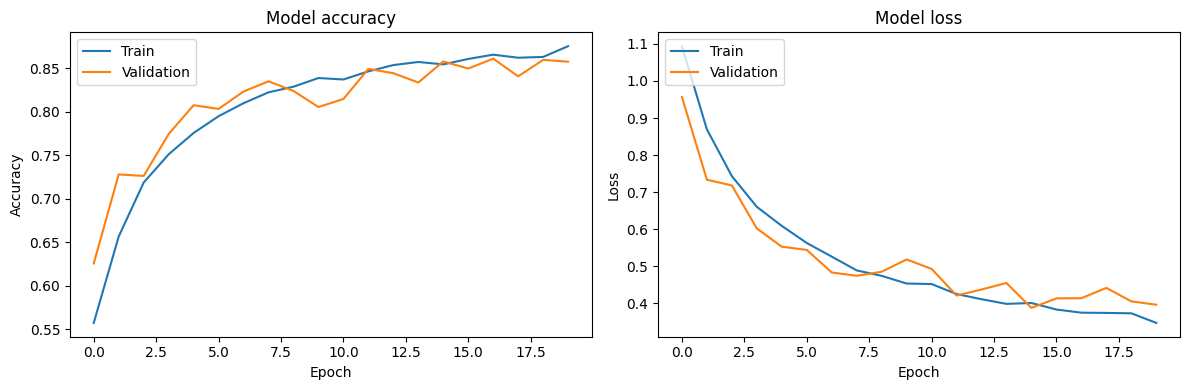

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Prediction**
----

In [15]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

W0000 00:00:1724183209.867726     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


The accuracy of the model for training data is: 87.53339052200317
The Loss of the model for training data is: 0.34946250915527344
The accuracy of the model for test data is: 86.69999837875366
The Loss of the model for test data is: 0.38692766427993774


W0000 00:00:1724183217.926600     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

 5/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step

W0000 00:00:1724183219.917990     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step


W0000 00:00:1724183224.232125     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**Confusion Matrix**

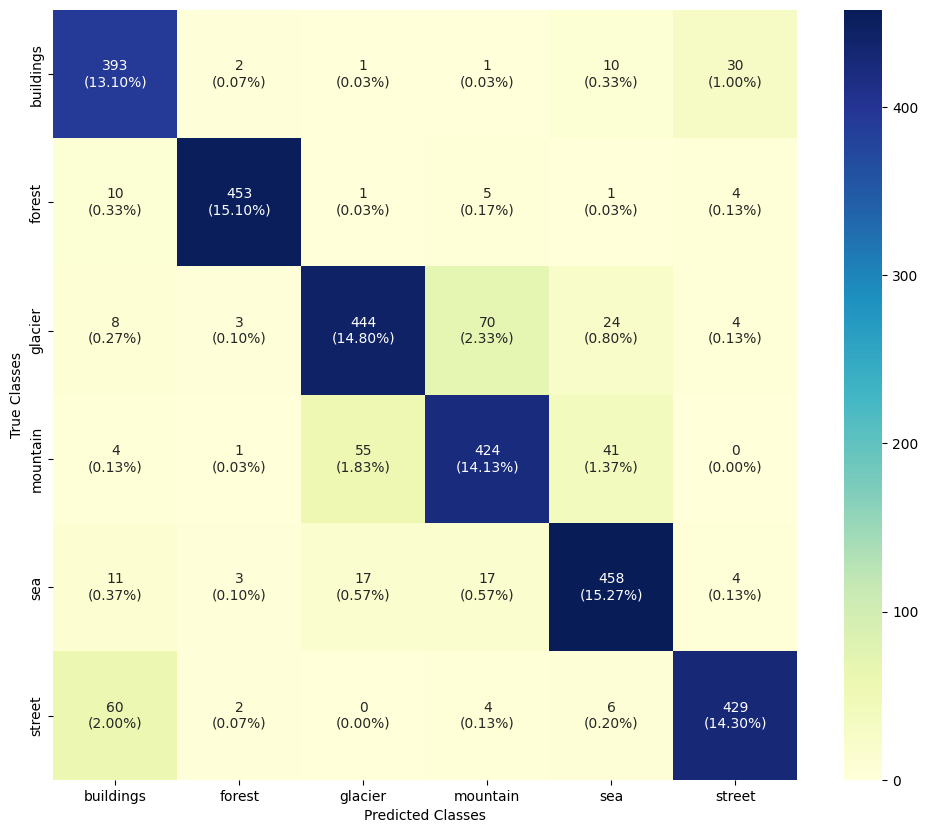

In [17]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**Classification Report**

In [18]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.81      0.90      0.85       437
      forest       0.98      0.96      0.97       474
     glacier       0.86      0.80      0.83       553
    mountain       0.81      0.81      0.81       525
         sea       0.85      0.90      0.87       510
      street       0.91      0.86      0.88       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



**Display Some Images With Predictions**

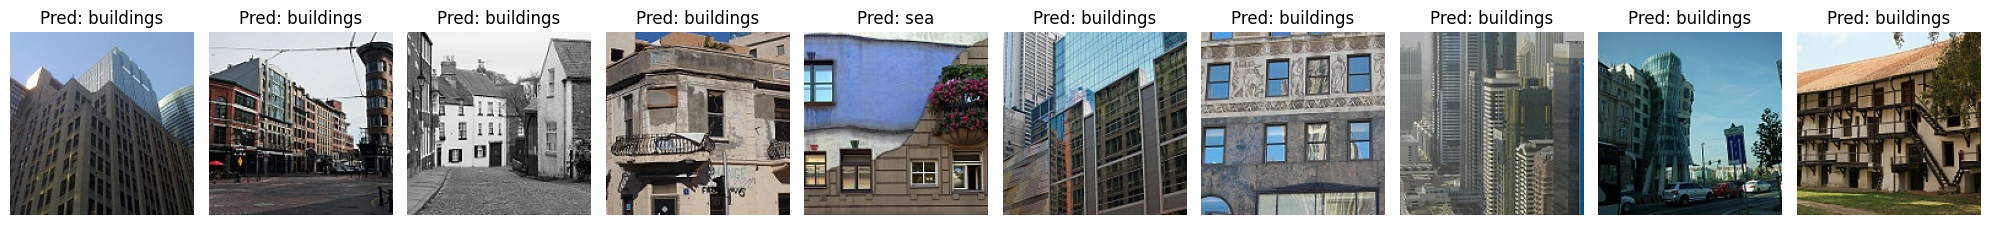

In [19]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)
